In [10]:
import pystan
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [11]:
#### Preprocecing ###

In [12]:
Confirmed = pd.read_csv("../csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")

In [13]:
df = Confirmed.groupby("Country/Region").sum()
df = df.drop(["Lat", "Long"], 1)
df = df.T
df = df.set_index(pd.to_datetime(df.index))
confirmed = df

In [14]:
contries = confirmed.max() >= 1000
confirmed = confirmed.loc[:, contries]
confirmed = confirmed.cummax()

In [15]:
df = pd.read_csv("../csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv")
df = df.groupby("Country/Region").sum()
df = df.drop(["Lat", "Long"], 1)
df = df.T
df = df.set_index(pd.to_datetime(df.index))
recovered = df.loc[:, contries]
recovered = recovered.cummax()


In [16]:
df = pd.read_csv("../csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv")
df = df.groupby("Country/Region").sum()
df = df.drop(["Lat", "Long"], 1)
df = df.T
df = df.set_index(pd.to_datetime(df.index))
death = df.loc[:, contries]
death = death.cummax()

In [17]:
### Data Preparation ###

In [18]:
country = 'Korea, South'
C0 = confirmed[country].values
R0 = (recovered)[country].values
D0 = death[country].values
P = 5000_0000
iter=100000
repeat = 1000

In [19]:
data = {'T': C0.shape[0], 'P': P, 'C0': C0, 'R0': R0, 'D0':D0}

In [20]:
### Model ###

In [21]:
sm = pystan.StanModel(file="turzin.stan")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_7ba6d17563748454d8034e538402909e NOW.


In [22]:
# Train the model and generate samples
fit = sm.sampling(data=data, iter=iter, init=0)

In [23]:
fit

Inference for Stan model: anon_model_7ba6d17563748454d8034e538402909e.
4 chains, each with iter=100000; warmup=50000; thin=1; 
post-warmup draws per chain=50000, total post-warmup draws=200000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf   5.06  7.4e-3   2.19   1.74   3.47   4.75   6.32  10.19  86911    1.0
b0         0.29  4.6e-5   0.01   0.27   0.28   0.29    0.3   0.32  80552    1.0
b1       6.1e-3  4.0e-6 1.0e-3 4.3e-3 5.4e-3 6.0e-3 6.8e-3 8.3e-3  66270    1.0
theta_b    0.42  3.6e-5   0.01    0.4   0.42   0.42   0.43   0.45 100615    1.0
b_date    40.41  9.2e-4   0.26   39.9  40.24  40.42  40.59  40.92  81206    1.0
q1         0.84  3.5e-4   0.14   0.49   0.76   0.87   0.94    1.0 159922    1.0
theta_q    0.14  3.0e-5 9.1e-3   0.12   0.13   0.14   0.14   0.15  90374    1.0
q_date    47.63  6.3e-3   1.81  43.72   46.5  47.75  48.89  50.82  82683    1.0
a          0.03  7.9e-7 3.6e-4   0.03   0.03   0.03   0.03   0.03 204455    1.0
d    

In [24]:
### Visualization functions ###

In [25]:
def sigmoid(x, theta, t0):
    return 1/(1 + np.exp(-theta*(x-t0)))

In [26]:
def simulate(init_inf, b0, b1, theta_b, b_date, q1, theta_q, q_date, a, d, horizon):
    S = init_inf;
    R = 0;
    D = 0;
    S_list = [S]
    R_list = [R]
    D_list = [D]
    b_list = [b0]
    q_list = [0]
    S0 = [0]
    R0 = [0]
    D0 = [D]
    for t in range(horizon):
        b = b0 + (b1-b0) * sigmoid(t, theta_b, b_date)
        I = (S - R - D) * b * (1 - S/P)
        q = q1 * sigmoid(t, theta_q, q_date)
        NR = a * (S - R - D)
        ND = d * (S - R - D)
        D = D + ND
        S = S + I
        R = R + NR
        S_list.append(S)
        R_list.append(R)
        D_list.append(D)
        b_list.append(b)
        q_list.append(q)
        S0.append(S0[-1]+q*I)
        R0.append(R0[-1]+a * (S0[-1] - R0[-1] - D0[-1]))
    data = pd.DataFrame({'S':np.array(S_list),
                        'R':np.array(R_list),
                        'D':np.array(D_list),
                        'b':np.array(b_list),
                        'q':np.array(q_list),
                        'S0':np.array(S0),
                        'R0':np.array(R0)},
                        index=pd.date_range(start=pd.to_datetime('2020-01-22'), periods=horizon+1, freq='D'))
    return data

In [27]:
def monte_carlo(fit, horizon):
    S = pd.DataFrame()
    R = pd.DataFrame()
    D = pd.DataFrame()
    b = pd.DataFrame()
    q = pd.DataFrame()
    S0 = pd.DataFrame()
    R0 = pd.DataFrame()
    I0 = pd.DataFrame()
    n = fit['init_inf'].shape[0]
    for k in range(repeat):
        i = np.random.randint(n)
        df = simulate(init_inf=fit['init_inf'][i],
                      b0=fit['b0'][i],
                      b1=fit['b1'][i],
                      theta_b=fit['theta_b'][i],
                      b_date=fit['b_date'][i],
                      q1=fit['q1'][i],
                      theta_q=fit['theta_q'][i],
                      q_date=fit['q_date'][i],
                      a=fit['a'][i],
                      d=fit['d'][i],
                      horizon=horizon)
        S = pd.concat([S, df['S']], axis=1)
        R = pd.concat([R, df['R']], axis=1)
        D = pd.concat([D, df['D']], axis=1)
        b = pd.concat([b, df['b']], axis=1)
        q = pd.concat([q, df['q']], axis=1)
        S0 = pd.concat([S0, df['S0']], axis=1)
        R0 = pd.concat([R0, df['R0']], axis=1)
        I0 = pd.concat([I0, df['S0'] - df['R0']], axis=1)
    return S, R, D, b, q, S0, R0, I0
    

In [28]:
def extract_series(fit, name):
    value_list = []
    for d in range(S0.shape[0]):
        vals = fit['{}[{}]'.format(name, d+1)]
        value_list.append(vals)
    data = np.array(value_list)
    return pd.DataFrame(data, 
                        index=confirmed.index)

In [43]:
def draw(simulated, real=None):
    graph=pd.DataFrame(index=simulated.index)
    simulated = simulated.dropna(axis=1)
    median = simulated.median(axis=1)
    upper = simulated.quantile(q=0.75, axis=1)
    lower = simulated.quantile(q=0.25, axis=1)
    if not real is None:
        graph['Real'] = real
    graph['Median'] = median
    graph['Upper'] = upper
    graph['Lower'] = lower
    sns.relplot(kind="line", data=graph, aspect=2)

In [30]:
S, R, D, b, q, S0, R0, I0 = monte_carlo(fit, 120)

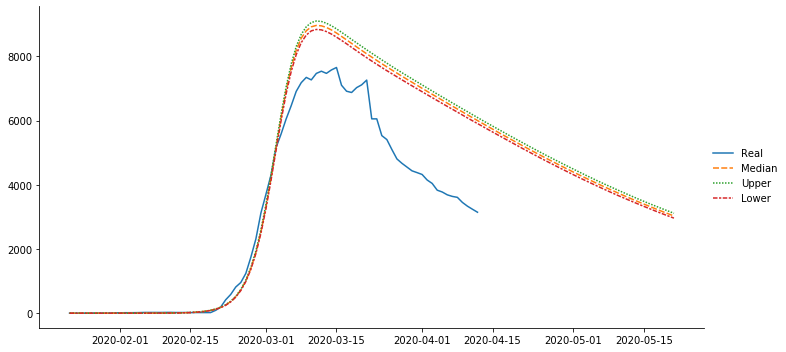

In [44]:
draw(I0, real=(confirmed-recovered)[country])

In [32]:
S.median(axis=1)[pd.to_datetime('2020-04-12')]

69379.19944276646

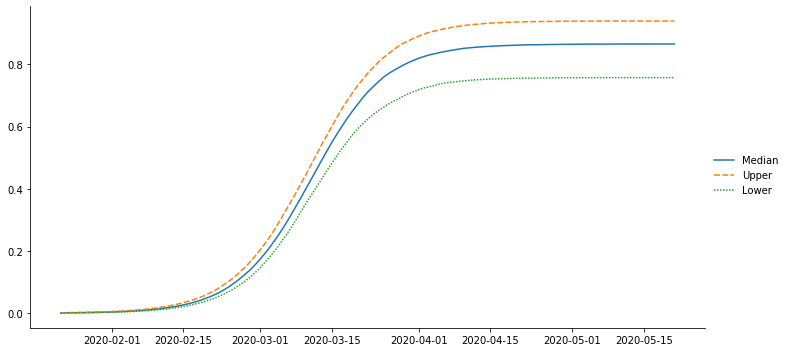

In [33]:
draw(q)

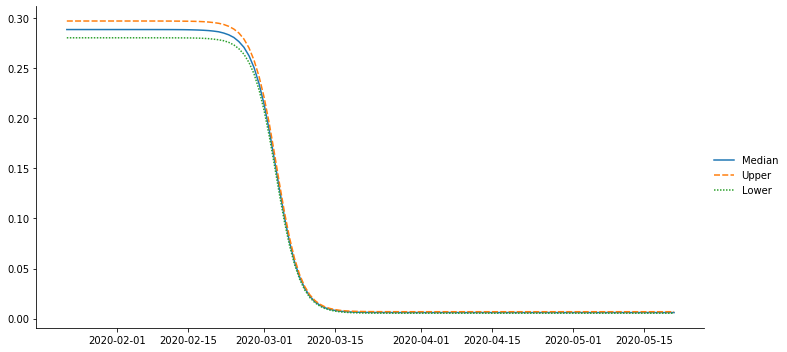

In [34]:
draw(b)

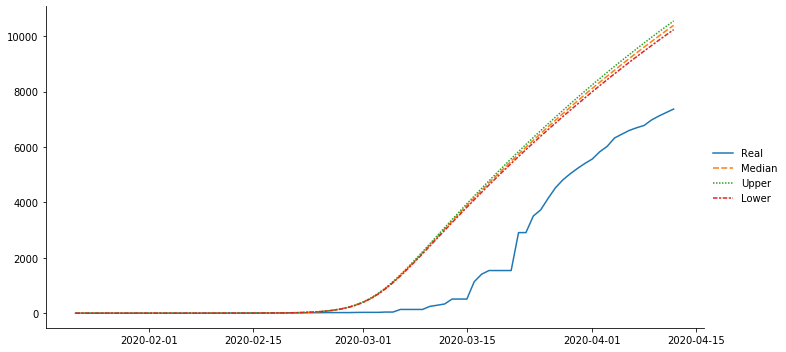

In [35]:
draw(R0, real=recovered[country])

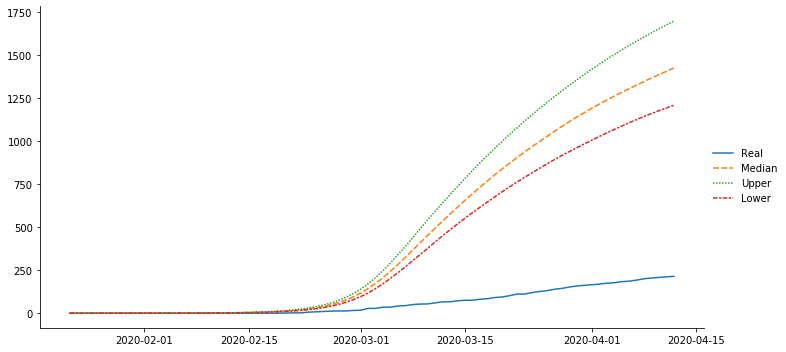

In [36]:
draw(D, real=death[country])

In [37]:
cumulative = pd.DataFrame(S.values, columns=range(len(S.columns)), index=pd.date_range(start=pd.to_datetime('2020-01-22'), periods=120+1, freq='D'))

In [38]:
predicted_recovered = pd.DataFrame(R.values, columns=range(len(R.columns)), index=pd.date_range(start=pd.to_datetime('2020-01-22'), periods=120+1, freq='D'))

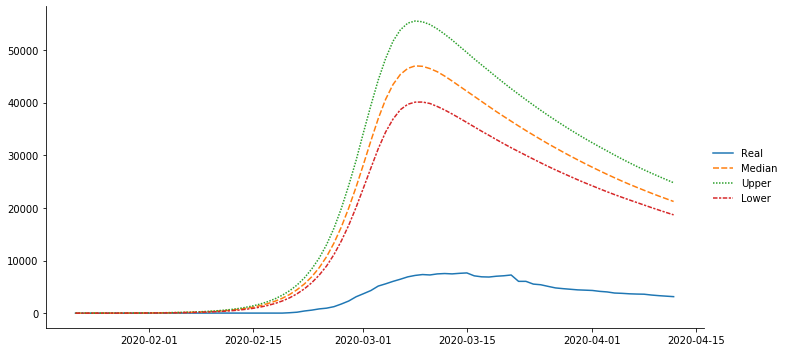

In [39]:
draw(cumulative - predicted_recovered, real=(confirmed-recovered)[country])

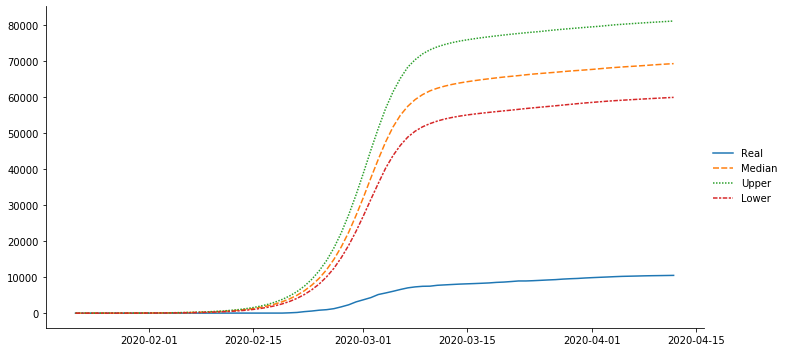

In [40]:
draw(cumulative, real=confirmed[country])

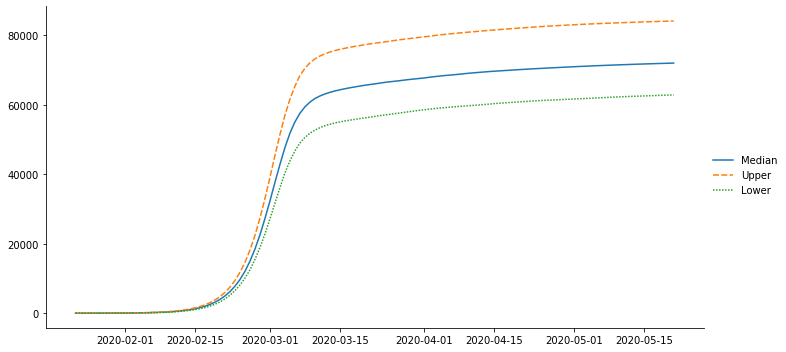

In [41]:
draw(S)

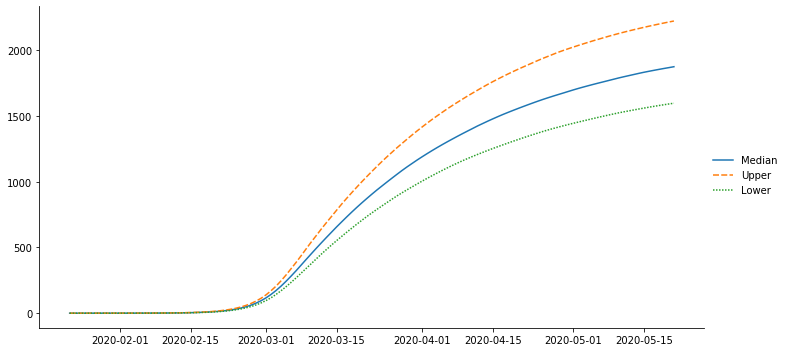

In [42]:
draw(D)